# <u>A/B Test Study on Website Recommendation Blocks<u>

# Introduction <a id='intro'></a>

This project aims to test the viability of adding Recommendation Blocks to our site. We inferred that there is reason to believe this marketing initiative will aid in channeling more visitors down the marketing funnel. Our goal in theory, would be to increase Average Order Size, and Conversion Rates based on the ratio of *number of transactions* to the *number of visits/sessions*.

**Initial Hypothesis: Recommendation Blocks on our website will increase Average Order Size and Conversion Rates.**

# Contents <a id='back'></a>

* [Introduction](#intro)
* [Stage 1. Libraries & Data Loading](#lib)
* [Stage 2. Data Pre-Processing](#dp)
* [Stage 3. Hypotheses Prioritization](#hp)
* [Stage 4. A/B Testing Analysis](#ab)
    * [4.1. Calculating Aggregated Cumulative Data](#ab1)
    * [4.2. Cumulative Revenue by Test Group](#ab2)
    * [4.3. Cumulative Average Order Size by Test Group](#ab3)
    * [4.4. Relative Difference in Cumulative Average Order Size](#ab4)
    * [4.5. Cumulative Conversion Rate by Group](#ab5)
    * [4.6. Checking for Outliers: Orders per User](#ab6)
    * [4.7. Checking for Outliers: Order Size per Transaction](#ab7)
    * [4.8. Statistical Significance of Difference in Conversion - Raw Data](#ab8)
    * [4.9. Statistical Significance of Difference in Average Order Size - Raw Data](#ab9)
    * [4.10. Statistical Significance of Difference in Conversion - Filtered Data](#ab10)
    * [4.11. Statistical Significance of Difference in Average Order Size - Filtered Data](#ab11)
    * [4.12. Stability Test on Filtered Cumulative Conversion Rate - Preventing the Peeking Problem](#ab12)
* [Stage 5. Findings & Overall Conclusion](#findings)

# 1. Libraries & Data Loading <a id='lib'></a>

In [41]:
import pandas as pd
import numpy as np
import math as math
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
try:
    hypo = pd.read_csv("hypotheses_us.csv", sep=';')
    orders = pd.read_csv("orders_us.csv")
    visits = pd.read_csv("visits_us.csv")
except:
    hypo = pd.read_csv("/datasets/hypotheses_us.csv", sep=';')
    orders = pd.read_csv("/datasets/orders_us.csv")
    visits = pd.read_csv("/datasets/visits_us.csv")

[Back to Contents](#back)

# 2. Data Pre-Processing <a id='dp'></a>

### HYPOTHESES:

In [43]:
# Overview
pd.set_option('display.max_colwidth', None)
display(hypo)
hypo.info(memory_usage='deep')

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 1.6 KB


### ORDERS:

In [44]:
# Overview:

display(orders.head(5))
display(orders.info(memory_usage='deep'))

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 174.3 KB


None

In [45]:
# Changing id column names to the snake case:

orders = orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'})

In [46]:
# Converting data types:
## 'date' > datetime

orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d', dayfirst=True)

In [47]:
# Finding potential entries of inconsistent A/B group splits:

## Splitting entries between both a/b groups
a_id = orders.query("group == 'A'")
b_id = orders.query("group == 'B'")

## Table of visitorId's with values in both a/b groups
ordersAB = orders[(orders['visitor_id'].isin(a_id['visitor_id'])) & (orders['visitor_id'].isin(b_id['visitor_id']))]
ordersAB = ordersAB.sort_values(by='visitor_id')
ordersAB

,transaction_id,visitor_id,date,revenue,group
703,4293855558,8300375,2019-08-07,30.5,A
71,3679129301,8300375,2019-08-01,165.7,B
823,2971973105,199603092,2019-08-27,45.9,A
246,437656952,199603092,2019-08-02,55.7,B
26,2223239646,199603092,2019-08-15,55.7,A
...,...,...,...,...,...
187,2048878902,4256040402,2019-08-17,25.8,A
114,1120327437,4256040402,2019-08-01,90.2,A
60,1421016313,4256040402,2019-08-16,875.5,B
662,1811671147,4266935830,2019-08-29,1220.2,A


**We found 181 entries that had inconsistent distribution of their A/B groups.  We unfortunately have to drop them as there is no telling which A/B test group these visitors originated from.**

In [48]:
# Dropping duplicates, obtaining visitor_ids that had inconsistent group distribution

ordersAB.drop_duplicates(subset='visitor_id', inplace=True)

# Filtering out bad visitor ids:
orders = orders.query("visitor_id not in @ordersAB.visitor_id")
orders.shape

(1016, 5)

### VISITS:

In [49]:
# Overview

display(visits.head())
visits.info(memory_usage='deep')

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 8.2 KB


In [50]:
# Converting date types:
## 'date' > datetime

visits['date'] = pd.to_datetime(visits['date'], format='%Y-%m-%d', dayfirst=True)

[Back to Contents](#back)

# 3. Hypotheses Prioritization <a id='hp'></a>

In [51]:
# Getting category identifiers for our hypotheses:

hypo_dict = {
    0: 'New Marketing Channels',
    1: 'Own Delivery Service',
    2: 'Product Reccomendation Blocks',
    3: 'New Site Category Structure',
    4: 'New Background Color',
    5: 'New Review Page',
    6: 'Promotional Banners',
    7: 'Subscription Form',
    8: 'Birthday Discount'
}

hypo['Initiative'] = hypo.index.map(hypo_dict)

In [52]:
# Calculating ICE and RICE frameworks respectively:

hypo['ICE'] = hypo.Impact * hypo.Confidence / hypo.Effort
hypo['RICE'] = hypo.Reach * hypo.Impact * hypo.Confidence / hypo.Effort

In [53]:
# Visualizing top hypotheses by ICE and RICE frameworks respectively:

print("\033[1m SORTED by ICE")
display(hypo.sort_values('ICE', ascending=False))
print()
print("\033[1m SORTED by RICE")
hypo.sort_values('RICE', ascending=False)

 SORTED by ICE


,Hypothesis,Reach,Impact,Confidence,Effort,Initiative,ICE,RICE
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,Birthday Discount,16.200000,16.2
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,New Marketing Channels,13.333333,40.0
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,Subscription Form,11.200000,112.0
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,Promotional Banners,8.000000,40.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,Product Reccomendation Blocks,7.000000,56.0
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10,Own Delivery Service,2.000000,4.0
5,Add a customer review page. This will increase the number of orders,3,2,2,3,New Review Page,1.333333,4.0
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,New Site Category Structure,1.125000,9.0
4,Change the background color on the main page. This will increase user engagement,3,1,1,1,New Background Color,1.000000,3.0



 SORTED by RICE


,Hypothesis,Reach,Impact,Confidence,Effort,Initiative,ICE,RICE
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,Subscription Form,11.200000,112.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,Product Reccomendation Blocks,7.000000,56.0
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,New Marketing Channels,13.333333,40.0
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,Promotional Banners,8.000000,40.0
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,Birthday Discount,16.200000,16.2
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,New Site Category Structure,1.125000,9.0
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10,Own Delivery Service,2.000000,4.0
5,Add a customer review page. This will increase the number of orders,3,2,2,3,New Review Page,1.333333,4.0
4,Change the background color on the main page. This will increase user engagement,3,1,1,1,New Background Color,1.000000,3.0


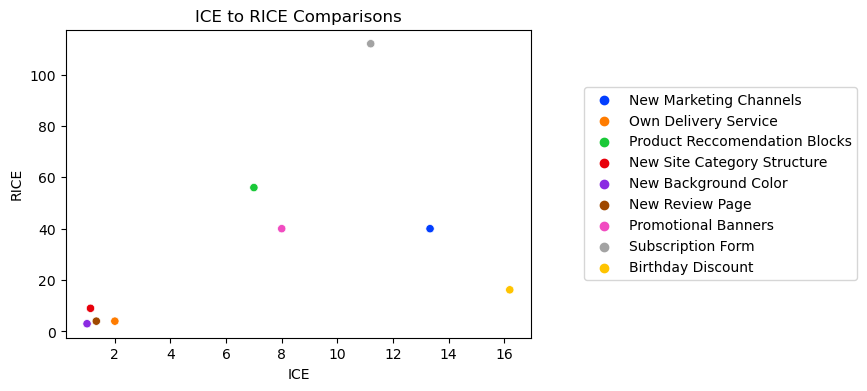

In [54]:
# Visualizing ICE and RICE prioritization:

plt.figure(figsize=(6,4))

sns.scatterplot(x='ICE', y='RICE', data=hypo, hue='Initiative', palette='bright')

plt.title('ICE to RICE Comparisons')
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), ncol=1)

plt.show()

**INTERMEDIATE CONCLUSION:**
<br><br>
Our top 3 ICE hypotheses and observations:
1. **Launching  birthday discount promotion** - This has a great Impact and Confidence rating as it is almost a certainty to ignite recurring purchases for visitors who have already converted. 
2. **Adding two new channels for increased website traffic** - This has the greatest Impact rating as it opens up new population markets that wasn't being catered to
3. **Adding a subscription form to allow for email-marketing** - This has a substantial Impact and Confidence rating as it aid in building customer engagement and relationship.
<br><br>

Adding the reach parameter to our ICE framework significantly changes the hierachy for prioritization. Our top 4 RICE hypotheses and observations:
1. **Adding a subscription form to allow for email-marketing** - This marketing initiative came in at no.1 in our RICE framework purely because it has the biggest Reach rating. Building a customer information database allows for direct targeting of users who already have us in their brand repertoire and enables re-targeting of past customers to increase retention rates.
2. **Adding product recommendation blocks** - 2nd on our list, but 5th in the ICE framework. This initiative has low Impact but high Reach ratings. Recommendation blocks allow us to better ease prospective customers along the marketing funnel with better relevancy of products they already know they want/need. Moreover, we also have to consider the fact that Effort rating is low, which means it is cost-effective to implement.
3. **Adding two new channels for increased website traffic** - This initiative came in 1 spot down compared to the ICE framework, due to the fact is has a pretty low Reach rating. However, the Impact component is a huge boon as this initiative will single-handedly create customer awareness for populations that were previously not targeted whatsoever. In essence then, this is quality over quantity.
4. **Adding promotional banners to show current sales and offers** - This brings value added offerings to the forefront which will lead to better conversion of both customers who are already in-market and those who are of the browsing nature.
<br>
<br>
**As an online platform, we are much more concerned about the reach of our marketing initiatives. The RICE framework caters to that and allows us to differentiate between 'big impact for a small audience' vs 'small impact for a big audience'.** 

[Back to Contents](#back)

# 4. A/B Testing Analysis <a id='ab'></a>

### 4.1. Calculating Aggregated Cumulative Data <a id='ab1'></a>

In [55]:
# Constructing an array of unique paired date-group values
datesGroups = orders[['date', 'group']].drop_duplicates()

# Daily cumulative aggregated data on ORDERS:
ordersAgg = (datesGroups
             .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
                    .agg({'date': 'max', 'group': 'max', 'transaction_id': 'nunique', 'visitor_id': 'nunique', 'revenue': 'sum'}),
                    axis=1)
             .sort_values(by=['date', 'group'])
            )

# Daily cumulative aggregated data on VISITS:
visitsAgg = (datesGroups
             .apply(lambda x: visits[np.logical_and(visits['date'] <= x['date'], visits['group'] == x['group'])]
                   .agg({'date': 'max', 'group': 'max', 'visits': 'sum'}),
                   axis=1)
             .sort_values(by=['date', 'group'])
            )

In [56]:
# Merging aggregated data:

cumulativeData = ordersAgg.merge(visitsAgg, on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'transactions', 'buyers', 'revenue', 'visits']

cumulativeData.head(10)

,date,group,transactions,buyers,revenue,visits
0,2019-08-01,A,23,19,2266.6,719
1,2019-08-01,B,17,17,967.2,713
2,2019-08-02,A,42,36,3734.9,1338
3,2019-08-02,B,40,39,3535.3,1294
4,2019-08-03,A,66,60,5550.1,1845
5,2019-08-03,B,54,53,4606.9,1803
6,2019-08-04,A,77,71,6225.6,2562
7,2019-08-04,B,68,66,6138.5,2573
8,2019-08-05,A,99,92,7623.6,3318
9,2019-08-05,B,89,87,7587.8,3280


[Back to Contents](#back)

### 4.2. Cumulative Revenue by Group <a id='ab2'></a>

In [57]:
# Splitting cumulative orders by group A/group B

cumulativeOrdersA = cumulativeData[cumulativeData['group'] == 'A'][['date', 'transactions', 'revenue']]
cumulativeOrdersB = cumulativeData[cumulativeData['group'] == 'B'][['date', 'transactions', 'revenue']]

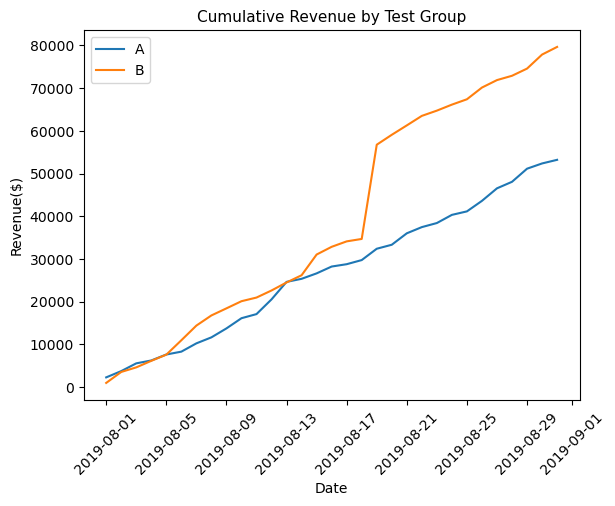

In [58]:
# Plotting cumulative Revenue for both test groups:

plt.plot(cumulativeOrdersA['date'], cumulativeOrdersA['revenue'], label='A')
plt.plot(cumulativeOrdersB['date'], cumulativeOrdersB['revenue'], label='B')

plt.title('Cumulative Revenue by Test Group', fontsize=11)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Revenue($)')
plt.xticks(rotation=45)

plt.show()

**Intermediate Conclusion:** For the most part, revenue for our test group is consistently higher than our control group. However, it is prudent to note that there is an enormous spike observed at around the 17th Aug mark. This is an evident outlier and could be caused by a surge in large and/or expensive orders.

[Back to Contents](#back)

### 4.3. Cumulative Average Order Size by Group <a id='ab3'></a>

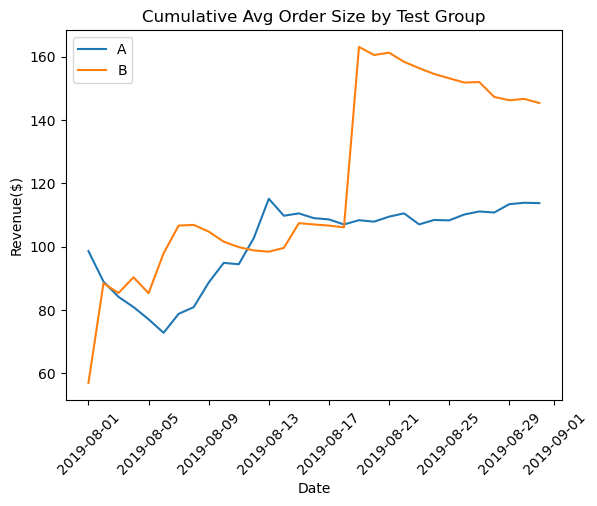

In [59]:
# Plotting average order size for each test group:

plt.plot(cumulativeOrdersA['date'], (cumulativeOrdersA['revenue'] / cumulativeOrdersA['transactions']), label='A')
plt.plot(cumulativeOrdersB['date'], (cumulativeOrdersB['revenue'] / cumulativeOrdersB['transactions']), label='B')

plt.title('Cumulative Avg Order Size by Test Group')
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Revenue($)')
plt.xticks(rotation=45)
plt.show()

**Intermediate Conclusion:** We can definitely observe lots of fluctuations throughout the first half of the month between both groups. Our control group seems to stabilize roughly from the middle of the month onwards, but our test group showed a substantial spike around the same time. Its clear that outliers are the cause for the spike and thus, this plot does not have conclusive value as of yet.

[Back to Contents](#back)

### 4.4. Relative Difference in Cumulative Average Order Size <a id='ab4'></a>

In [60]:
# Merging cumulative orders of both groups for relative difference calculations:

cumulativeOrdersMerged = cumulativeOrdersA.merge(cumulativeOrdersB, on='date', suffixes=['A', 'B'])

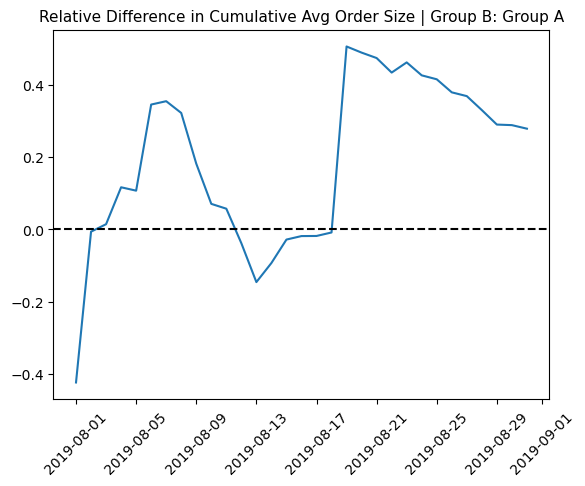

In [61]:
# Plotting relative difference in cumulative avg order size of group B compared to group A:

plt.plot(cumulativeOrdersMerged['date'], 
         (cumulativeOrdersMerged['revenueB'] / cumulativeOrdersMerged['transactionsB'])
        /
        (cumulativeOrdersMerged['revenueA'] / cumulativeOrdersMerged['transactionsA'])
        - 1
        )

plt.axhline(y=0, color='black', linestyle='--') 

plt.title('Relative Difference in Cumulative Avg Order Size | Group B: Group A', fontsize=11)
plt.xticks(rotation=45)
plt.show()

**Intermediate Conclusion:** Yet again, there are major spikes in favor of our test group, B. There is almost a certainty outliers of immensely big orders have a role to play in this. Moreover, there doesn't seem to be any semblance of stability whatsoever throughout the graph.

[Back to Contents](#back)

### 4.5. Cumulative Conversion Rate by Group <a id='ab5'></a>

In [62]:
# Calculating conversion rates as the ratio of orders to the number of visits each day:
cumulativeData['conversion'] = cumulativeData['transactions'] / cumulativeData['visits']

# Splitting cumulative data by Group A/Group B:
cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

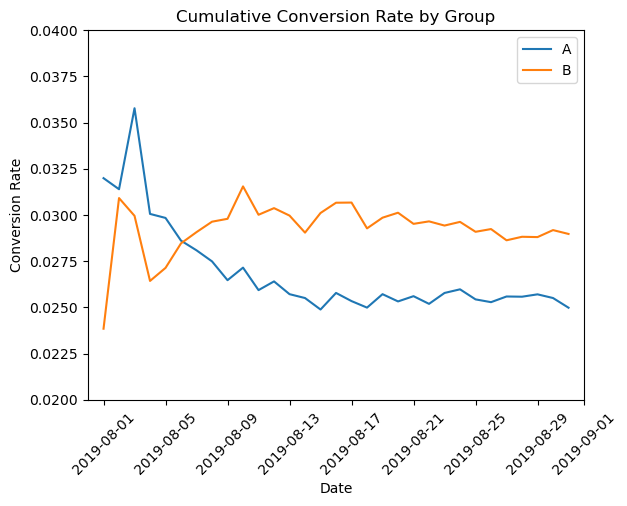

In [63]:
# Plotting cumulative conversion for each group:

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.title('Cumulative Conversion Rate by Group')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)

plt.axis([pd.to_datetime('2019-07-31'), pd.to_datetime('2019-09-01'), 0.02, 0.04]) 
plt.show()

In [64]:
# Merging conversions of group A and group B:

cumulativeConversion = (cumulativeDataA[['date', 'conversion']]
                        .merge(cumulativeDataB[['date', 'conversion']], on='date', suffixes=['_A', '_B'])) 

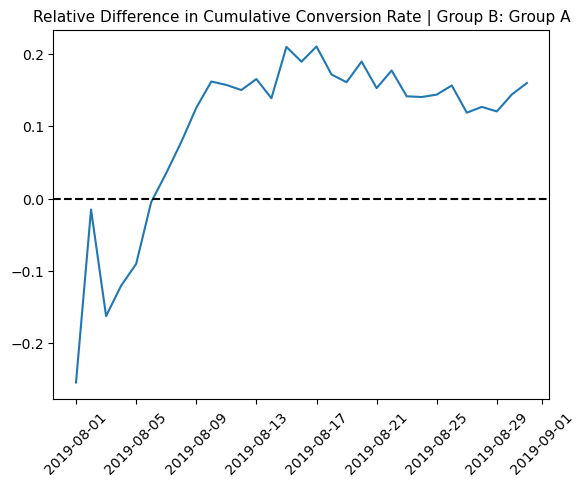

In [65]:
# Plotting relative difference in relative cumulative conversion rate of group B compared to group A:


plt.plot(cumulativeConversion['date'], cumulativeConversion['conversion_B'] / cumulativeConversion['conversion_A'] - 1)

plt.axhline(y=0, color='black', linestyle='--') 

plt.title('Relative Difference in Cumulative Conversion Rate | Group B: Group A', fontsize=11)
plt.xticks(rotation=45)
plt.show()

**Intermediate Conclusion:** Group A, our control group had a higher conversion rate at the start of our test. However, group B quickly took the lead in the first week of our test and shows stablization from the middle of the month onwards. In a vacuum, our test group, B seems to be converting doing a better job in the conversion metric when compared to our control group, A.

[Back to Contents](#back)

### 4.6. Checking for Outliers: Orders per User <a id='ab6'></a>

In [66]:
# aggreating number of unique transactions for each unique visitor:
ordersByVisitor = (orders
                   .groupby('visitor_id', as_index=False)
                   .agg({'transaction_id': 'nunique'})
                  )
ordersByVisitor.columns = ['visitor_id', 'orders']

# sorting by number of orders to find visitors with substantially more orders than the avg:
ordersByVisitor.sort_values('orders', ascending=False).head(15)

,visitor_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


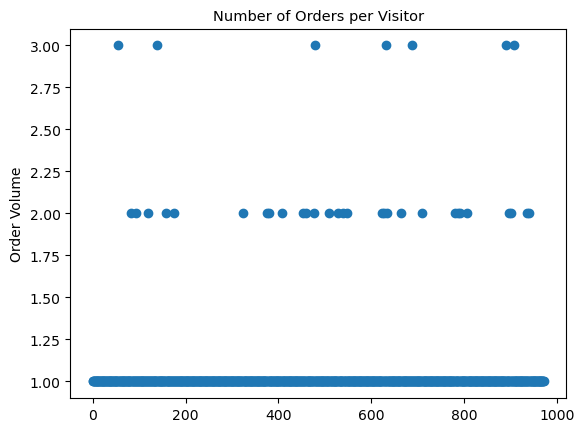

In [67]:
# Plotting a scatterplot to visualize observed outliers:

plt.scatter(pd.Series(range(len(ordersByVisitor))), ordersByVisitor['orders'])

plt.title('Number of Orders per Visitor', fontsize=10.5)
plt.ylabel('Order Volume')
plt.show()

**Observations:** It is clear from our scatterplot that the average order volume per user over the course of a 1 month test period is 1. Anything above that are considerable anomalies and outliers. This observation also explains our spikes in our analysis on cumulative revenue.

In [68]:
# Calculating the 90th, 95th and 99th percentile values for our buyers:

percen = np.percentile(ordersByVisitor['orders'], [90, 95, 99])
print(f"90th Percentile Order Volume: {percen[0]}")
print(f"95th Percentile Order Volume: {percen[1]}")
print(f"99th Percentile Order Volume: {percen[2].round(1)}")


90th Percentile Order Volume: 1.0
95th Percentile Order Volume: 1.0
99th Percentile Order Volume: 2.0


**Intermediate Conclusion:** Taking 99th percentile as our threshold for anomalies, our prior observations hold true in that we have some anomalies in customer who order more than the average(1).

[Back to Contents](#back)

### 4.7. Checking for Outliers: Order Size per Transaction<a id='ab7'></a>

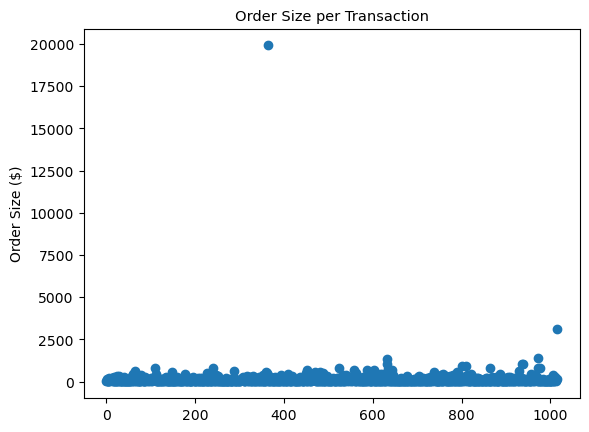

In [69]:
# Plotting a scatterplot on revenue to visualize possible anomalies:

plt.scatter(pd.Series(range(len(orders['revenue']))), orders['revenue'])

plt.title('Order Size per Transaction', fontsize=10.5)
plt.ylabel('Order Size ($)')
plt.show()

**Observations:** We observe 2 obvious anomalies roughly around the \\$2,500 and \\$20,000 mark. These are considerably extreme values that explain our sudden spikes in our analysis on average cumulative order size.

In [70]:
# Calculating the 90th, 95th and 99th percentile values for transactions:

percen = np.percentile(orders['revenue'], [90, 95, 99])
print(f"90th Percentile Order Size: {percen[0]}")
print(f"95th Percentile Order Size: {percen[1]}")
print(f"99th Percentile Order Size: {percen[2].round(2)}")

90th Percentile Order Size: 280.8
95th Percentile Order Size: 414.275
99th Percentile Order Size: 830.3


**Intermediate Conclusions:** We will use our 99th percentile (\\$830.30) as a starting point for finding outliers. 

[Back to Contents](#back)

### 4.8. Statistical Significance of Difference in Conversion - Raw Data<a id='ab8'></a>

**N/B: Seeing as we have indications that anomalies are present in our test data, we will proceed with the Mann-Whitney U Test**.

In [71]:
# Assigning a value of 1 for every entry of our orders table for MWU ranking purposes:
orders['order_count'] = 1

# Getting a list of website visits that resulted in conversion for each group:
visitsConvertedA = orders.query("group == 'A'")['order_count']
visitsConvertedB = orders.query("group == 'B'")['order_count']

In [72]:
# Creating MWU ranking samples by joining visit entries that resulted in conversion on top of visit entries that did not:

sampleA = pd.concat(
    [visitsConvertedA, pd.Series(
        0, index=np.arange(
            visits[visits['group'] == 'A']['visits'].sum() - len(visitsConvertedA)), name='orders')],
    axis=0)

sampleB = pd.concat(
    [visitsConvertedB, pd.Series(
        0, index=np.arange(
            visits[visits['group'] == 'B']['visits'].sum() - len(visitsConvertedB)), name='orders')],
    axis=0)

In [73]:
# Getting our p-value from our MWU test:
print('P-Value:', ((st.mannwhitneyu(sampleA, sampleB)[1]) * 100).round(2),'%')

# Getting relative difference of conversion rate for Group B compared to Group A:
print('Relative Difference:',round((sampleB.mean() / sampleA.mean() - 1) * 100, 2),'%')

P-Value: 1.69 %
Relative Difference: 15.98 %


**Intermediate Conclusion:** Assuming a significance level of 5%, our H0 hypothesis is rejected as we have reached statistical significance; there is a significant difference between conversion rates of both groups. Moreover, our relative difference of roughly 16% is quite substantial. However, we need to remember the presence of our outliers found prior to this.

[Back to Contents](#back)

### 4.9. Statistical Significance of Difference in Average Order Size - Raw Data<a id='ab9'></a>

In [74]:
# Calculating the MWU Test for revenue:
print('P-Value:', ((
    st.mannwhitneyu(orders[orders['group'] == 'A']['revenue'], orders[orders['group'] == 'B']['revenue'])[1]) * 100)
      .round(2), '%')

# Calculating relative difference in average order size between groups:
print(
    'Relative Difference:', round((orders[orders['group'] == 'B']['revenue'].mean() 
                                  / orders[orders['group'] == 'A']['revenue'].mean() - 1) * 100,
                                  2), '%')

P-Value: 86.22 %
Relative Difference: 27.83 %


**Intermediate Conclusion:** Assuming a significance level of 5%, our H0 hypothesis can't be rejected as we are well above our alpha value; there is no significant difference between average order sizes of both groups. However, our relative difference of roughly 28% says otherwise.

[Back to Contents](#back)

### 4.10.  Statistical Significance of Difference in Conversion - Filtered Data<a id='ab10'></a>

**<u>Recap on Prior Percentile Calculations:<u>**
    
ORDER VOLUME Percentiles:

90th Percentile Order Volume: 1.0
<br>95th Percentile Order Volume: 1.0
<br>99th Percentile Order Volume: 2.0

    
ORDER SIZE Percentiles:

90th Percentile Order size: 280.8
<br>95th Percentile Order size: 414.275
<br>99th Percentile Order size: 830.30

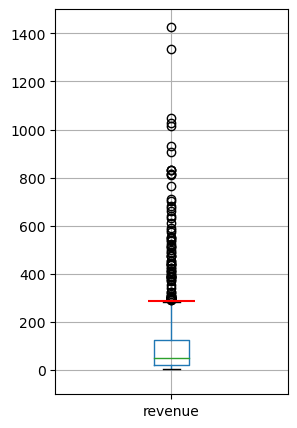

In [75]:
# Finding the point at which our values along the vertical axis deviate substantially:

Q1 = orders['revenue'].quantile(0.25)
Q3 = orders['revenue'].quantile(0.75)
IQR = Q3 - Q1

orders.boxplot(column=['revenue'], grid=True, figsize=(3,5))
plt.ylim(-100, 1500)
plt.hlines(y=Q1-1.5*IQR, xmin=0.9, xmax=1.1, color='red')
plt.hlines(y=Q3+1.5*IQR, xmin=0.9, xmax=1.1, color='red')
plt.show()

**There is an observable increment after a cluster of values above \\$750.**

In [76]:
# Finding users who fit our criteria of anomalous behaviour:

usersManyOrders = (orders
                        .groupby('visitor_id', as_index=False)['transaction_id'].nunique()
                        .query("transaction_id > 1")['visitor_id']
                       )

usersExpensiveOrders = (orders
                        .query('revenue > 750')['visitor_id']
                       )


anomalousUsers = pd.concat([usersManyOrders, usersExpensiveOrders], axis=0)\
                    .drop_duplicates()\
                    .sort_values()

In [77]:
# Creating a copy of filtered users:

ordersFiltered = orders.query("visitor_id not in @anomalousUsers").reset_index(drop=True)
ordersFiltered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  922 non-null    int64         
 1   visitor_id      922 non-null    int64         
 2   date            922 non-null    datetime64[ns]
 3   revenue         922 non-null    float64       
 4   group           922 non-null    object        
 5   order_count     922 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 43.3+ KB


In [78]:
# Getting a list of website visits that resulted in conversion for each group:
visitsConvertedA = ordersFiltered.query("group == 'A'")['order_count']
visitsConvertedB = ordersFiltered.query("group == 'B'")['order_count']

# Creating MWU ranking samples by joining visit entries that resulted in conversion on top of visit entries that did not:
sampleA = pd.concat(
    [visitsConvertedA, pd.Series(
        0, index=np.arange(
            visits[visits['group'] == 'A']['visits'].sum() - len(visitsConvertedA)), name='orders')],
    axis=0)

sampleB = pd.concat(
    [visitsConvertedB, pd.Series(
        0, index=np.arange(
            visits[visits['group'] == 'B']['visits'].sum() - len(visitsConvertedB)), name='orders')],
    axis=0)

# Printing our prior unfiltered figures:
print('Raw Data - P-Value: 1.69%')
print('Raw Data - Relative Difference: 15.98%')
print()

# Getting our p-value from our MWU test:
print('Filtered Data - P-Value:', ((st.mannwhitneyu(sampleA, sampleB)[1]) * 100).round(2),'%')

# Getting relative difference of conversion rate for Group B compared to Group A:
print('Filtered Data - Relative Difference:',round((sampleB.mean() / sampleA.mean() - 1) * 100, 2),'%')

Raw Data - P-Value: 1.69%
Raw Data - Relative Difference: 15.98%

Filtered Data - P-Value: 0.65 %
Filtered Data - Relative Difference: 19.43 %


**Intermediate Conclusion:** After filtering out outliers, we achieved a lower P-Value in our MWU test. We can still reject our Null hypothesis; there is a significant difference between test groups. Moreover, we saw a positive increase in our relative difference in conversion rate for test Group B compared to control Group A (16% to 20%).

[Back to Contents](#back)

### 4.11.  Statistical Significance of Difference in Average Order Size - Filtered Data<a id='ab11'></a>

In [79]:
# Printing our prior unfiltered figures:
print('Raw Data - P-Value: 86.22%')
print('Raw Data - Relative Difference: 27.83%')
print()

# Calculating the MWU Test for revenue:
print('Filtered Data - P-Value:', ((
    st.mannwhitneyu(ordersFiltered[ordersFiltered['group'] == 'A']['revenue'], 
                    ordersFiltered[ordersFiltered['group'] == 'B']['revenue'])[1]) * 100)
      .round(2), '%')

# Calculating relative difference in average order size between groups:
print(
    'Filtered Data - Relative Difference:', round((ordersFiltered[ordersFiltered['group'] == 'B']['revenue'].mean() 
                                  / ordersFiltered[ordersFiltered['group'] == 'A']['revenue'].mean() - 1) * 100,
                                  2), '%')

Raw Data - P-Value: 86.22%
Raw Data - Relative Difference: 27.83%

Filtered Data - P-Value: 87.09 %
Filtered Data - Relative Difference: 4.34 %


**Intermediate Conclusion:** Post-filtering, our P-Value still remains extremely high; our Null hypothesis cannot be rejected as we did not reach statistical significance. There isn't an observed difference between average order size for both groups. However, our relative difference is now more in line with our P-value. There is now only a miniscule increase of about 4% in average order size for our Test group B compared to Control group A, but this is negligible. Overall, no significant change was observed.

[Back to Contents](#back)

### 4.12.  Stability Test on Filtered Cumulative Conversion Rate - Preventing the Peeking Problem<a id='ab12'></a>

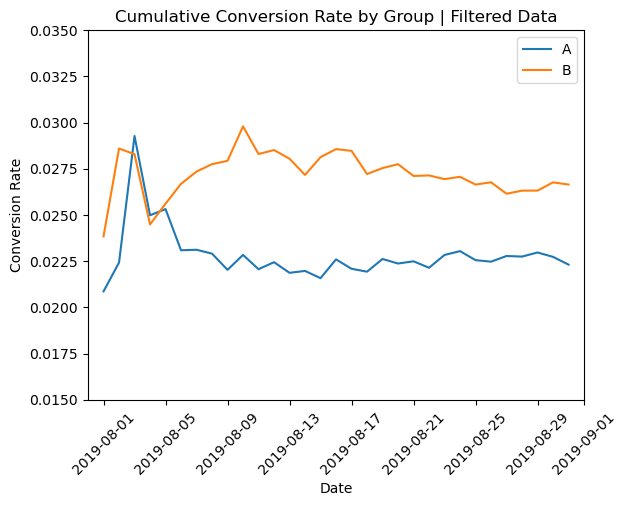

In [80]:
# Plotting our cumulative conversion rate based on filtered data:

datesGroups = ordersFiltered[['date', 'group']].drop_duplicates()
ordersAgg = (datesGroups
             .apply(lambda x: ordersFiltered[np.logical_and(ordersFiltered['date'] <= x['date'], ordersFiltered['group'] == x['group'])]
                    .agg({'date': 'max', 'group': 'max', 'transaction_id': 'nunique', 'visitor_id': 'nunique', 'revenue': 'sum'}),
                    axis=1)
             .sort_values(by=['date', 'group'])
            )
visitsAgg = (datesGroups
             .apply(lambda x: visits[np.logical_and(visits['date'] <= x['date'], visits['group'] == x['group'])]
                   .agg({'date': 'max', 'group': 'max', 'visits': 'sum'}),
                   axis=1)
             .sort_values(by=['date', 'group'])
            )
cumulativeData = ordersAgg.merge(visitsAgg, on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'transactions', 'buyers', 'revenue', 'visits']


cumulativeData['conversion'] = cumulativeData['transactions'] / cumulativeData['visits']

cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.title('Cumulative Conversion Rate by Group | Filtered Data')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)

plt.axis([pd.to_datetime('2019-07-31'), pd.to_datetime('2019-09-01'), 0.015, 0.035]) 
plt.show()

**Intermediate Conclusion**: Based on our conversion metric based off of filtered data, of which had an observable and statistically significant difference, we can see some semblance of stability at roughly slightly after the 3rd week of the test period.

[Back to Contents](#back)

# 5. Findings & Overall Conclusion <a id='findings'></a>

Our experiment on implementing Recommendation Blocks on our website has proved fruitful, and our initial hypothesis is accepted. We have every reason to believe test group B has had a profound impact. While it did not affect average order size, it has successfully converted more visits into transactions by roughly 20%. More users were succesfully channeled further down the marketing funnel, meaning to say we had captured those customers who were perhaps on the fence prior to this experiment and/or customers who were of the nature of window-shoppers. Here is how we came to our conclusion:

1. Average Order Size by transaction: With our plot on [cumulative average order size based off of raw data](#ab3), we observed Test Group B hovering slightly below Control group A before spiking upwards midway through the test period. Removing the anomalies that skewed our data proved to stabilize our results, as we saw no statistical significant difference in our MannWhitney U test, while achieving close to null relative difference between groups (< 5%). ***Test Group B has not had an effect on the Average Order Size metric***. 

2. Conversion Rate: Harking back to the graph on [cumulative conversion rate based off of raw data](#ab5), we observed Test group B pulling ahead compared to Control group A at roughly the middle of the test period. Both groups stabilized and plateaued after the fact, with neither an incline or decline observed. We tested the validity of this result based on filtered data and found that our prior observations were not only true, but had improved. We obtained a P-Value that had reached statistical significance and a relative difference of close to 20% in favor of Test group B. ***Test Group B is deemed successful in affecting positive change in the conversion metric***.

> **<u>As our [conversion graph on filtered data](#ab12) seems to have stabilized somewhat after the 3/4 point of the experiment, it would be justifiable to stop the test, conclude Group B our winner, and proceed with implementing Recommendation Blocks to our website for the forseeable future.</u>**

[Back to Contents](#back)